#**Transcriptome Annotation and Alternative Splicing Analysis of the Chicken Genome (GRCg7b)**

## By: Hera Dashnyam
## Under the Guidance of: Dr. Chun Liang
****

We aim to:

* Classify transcripts as known (matching reference genes) or novel (new predictions).

* Quantify the number of overlapping and non-overlapping transcripts between the two datasets.

* Identify isoform diversity, measuring how many transcript variants exist per gene.

* Detect alternative splicing signals by comparing exon boundaries between isoforms.

* Visualize gene structure, highlighting exon-intron layouts of highly spliced genes.

* Evaluate biological significance, including potential functional diversity driven by transcript variation.

By integrating pybedtools, bedtools, and transcriptome annotations, this workflow gives insights into the complexity of gene expression in chicken tissues and highlights candidates for further study of gene regulation and novel gene discovery.

****
###**Tools & Files**

In [ ]:
%pip install pybedtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 27.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 19.3 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.12.0-cp311-cp311-linux_x86_64.whl size=14261442 sha256=68745366db1fdc1ba862a47d82025abeaf765a3432fd5338ea261436717fdb56
  Stored in directory: /root/.cache/pip/wheels/95/62/57/e8c47c2a43884227b6644cf1d2dabf3162a0f40b9c1493c1f5
Successfully built pybedtools


In [ ]:
!apt-get install -y bedtools

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 563 kB of archives.
After this operation, 1,548 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 bedtools amd64 2.30.0+dfsg-2ubuntu0.1 [563 kB]
Fetched 563 kB in 1s (1,036 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../bedtools_2.30.0+dfsg-2ubuntu0.1_amd64.deb ...
Unpacking bedtools (2.30.0+dfsg-2ubuntu0.1) ...
Setting up bedtools (2.30.0+dfsg-2ubuntu0.1) ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pybedtools import BedTool
from collections import defaultdict
import re

# Load files
merged_gtf = BedTool('/content/drive/MyDrive/HeraDashnyam/YapPool_merged.gtf')
reference_gff3 = BedTool('/content/drive/MyDrive/HeraDashnyam/Gallus_gallus.bGalGal1.mat.broiler.GRCg7b.113.gff3')

# ----------------------------
# Classify each gene
# ----------------------------
gene_transcripts = defaultdict(list)
gene_has_ref = defaultdict(bool)

for f in merged_gtf:
    if f[2] == 'transcript':
        attrs = dict(re.findall(r'(\S+)\s+"([^"]+)"', f[8]))
        gene_id = attrs.get('gene_id', '')
        transcript_id = attrs.get('transcript_id', '')
        ref_gene_id = attrs.get('ref_gene_id', None)
        gene_transcripts[gene_id].append((transcript_id, ref_gene_id))
        if ref_gene_id:
            gene_has_ref[gene_id] = True

# ----------------------------
# Define Categories 1–4
# ----------------------------
category_counts = {
    "Category 1": 0,  # Novel transcriptome, novel isoforms only
    "Category 2": 0,  # Novel transcriptome, known + novel isoforms
    "Category 3": 0,  # Known transcriptome, known isoforms only
    "Category 4": 0   # Known transcriptome, known + novel isoforms
}
other_gene_ids = set()

for gene_id, transcript_list in gene_transcripts.items():
    is_mstrg = gene_id.startswith("MSTRG")
    has_ref = gene_has_ref[gene_id]

    if is_mstrg:
        if has_ref:
            category_counts["Category 2"] += 1
        else:
            category_counts["Category 1"] += 1
    elif gene_id.startswith("ENSGALG") or gene_id.startswith("ENSGALT"):
        if has_ref:
            category_counts["Category 4"] += 1
        else:
            category_counts["Category 3"] += 1
    else:
        other_gene_ids.add(gene_id)

# ----------------------------
# Overlap Test (SubTask02b)
# ----------------------------
mstrg_transcripts = merged_gtf.filter(lambda f: 'gene_id "MSTRG' in f[8] and f[2] == 'transcript').saveas()
collapsed_mstrg_genes = mstrg_transcripts.sort().merge(s=True, c=8, o="distinct").saveas()

ref_genes = reference_gff3.filter(lambda f: f[2] == 'gene').saveas()
ref_transcripts = reference_gff3.filter(lambda f: f[2] in ['mRNA', 'transcript']).saveas()

ovlp_genes = collapsed_mstrg_genes.intersect(ref_genes, u=True)
ovlp_trans = mstrg_transcripts.intersect(ref_transcripts, u=True)

# ----------------------------
# Final Output Dictionary
# ----------------------------
result = {
    "Category Counts": {
        "Category 1 (Pure Novel MSTRG)": category_counts["Category 1"],
        "Category 2 (MSTRG with known isoforms)": category_counts["Category 2"],
        "Category 3 (Known gene, only known isoforms)": category_counts["Category 3"],
        "Category 4 (Known gene, known + novel isoforms)": category_counts["Category 4"],
        "Other gene IDs": len(other_gene_ids)
    },
    "SubTask02b": {
        "MSTRG_genes_with_overlap": len(ovlp_genes),
        "MSTRG_transcripts_with_overlap": len(ovlp_trans)
    }
}

print(result)

{'Category Counts': {'Category 1 (Pure Novel MSTRG)': 1162, 'Category 2 (MSTRG with known isoforms)': 19157, 'Category 3 (Known gene, only known isoforms)': 0, 'Category 4 (Known gene, known + novel isoforms)': 8466, 'Other gene IDs': 0}, 'SubTask02b': {'MSTRG_genes_with_overlap': 13612, 'MSTRG_transcripts_with_overlap': 67487}}


In [ ]:
from pybedtools import BedTool
from collections import defaultdict
import pandas as pd
import re

# Load your merged GTF file
merged_gtf = BedTool('/content/drive/MyDrive/HeraDashnyam/YapPool_merged.gtf')

# Classify gene-transcript relationships based on presence of ref_gene_id
gene_transcripts = defaultdict(list)
gene_has_ref = defaultdict(bool)

for f in merged_gtf:
    if f[2] == 'transcript':
        attrs = dict(re.findall(r'(\S+)\s+"([^"]+)"', f[8]))
        gene_id = attrs.get('gene_id', '')
        transcript_id = attrs.get('transcript_id', '')
        ref_gene_id = attrs.get('ref_gene_id', None)
        gene_transcripts[gene_id].append((transcript_id, ref_gene_id))
        if ref_gene_id:
            gene_has_ref[gene_id] = True

# Build classification table
records = []

for gene_id, transcripts in gene_transcripts.items():
    is_mstrg = gene_id.startswith("MSTRG")
    has_ref = gene_has_ref[gene_id]
    for transcript_id, ref in transcripts:
        if is_mstrg:
            if has_ref:
                category = "Category 2"  # Novel transcriptome with known overlaps
            else:
                category = "Category 1"  # Fully novel
        else:
            if has_ref:
                category = "Category 4"  # Known gene with both types
            else:
                category = "Category 3"  # Fully known
        records.append({
            "gene_id": gene_id,
            "transcript_id": transcript_id,
            "ref_gene_id": ref if ref else "",
            "category": category
        })

# Save to Excel
df = pd.DataFrame(records)
df.to_excel("YapPool_Transcript_Categories.xlsx", index=False)

***
### **Distribution of Gene Categories in YapPool_merge.gtf**

| Category #     | Label                                                    | Definition                                                                                                                                                                                |
| -------------- | -------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Category 1** | *Novel transcriptome with only novel isoforms*           | `gene_id` starts with `MSTRG` and **none** of its transcripts have `ref_gene_id` (completely novel gene and isoforms)                                                                     |
| **Category 2** | *Novel transcriptome with both novel and known isoforms* | `gene_id` starts with `MSTRG` and **some** transcripts have `ref_gene_id` (novel gene structure but overlapping known isoforms)                                                           |
| **Category 3** | *Known transcriptome with only known isoforms*           | `gene_id` starts with `ENSGALG` or `ENSGALT` and **no** transcripts are novel (`MSTRG`) or contain `ref_gene_id`                                                                          |
| **Category 4** | *Known transcriptome with both known and novel isoforms* | `gene_id` starts with `ENSGALG`/**`ENSGALT`**, and its set of transcripts includes both known (overlapping or matching reference) **and** novel `MSTRG` isoforms assigned during assembly |

> Table 1. Category 3 — defined as known transcriptomes with only known isoforms — did not appear in this dataset. This is expected, because the merged transcriptome was assembled using StringTie, which typically assigns all output gene IDs as synthetic identifiers (e.g., MSTRG.*). As a result, even known transcripts from the reference annotation are often grouped under these synthetic MSTRG gene IDs when merged with novel transcripts. Consequently, purely known transcriptomes (i.e., known genes without any novel isoforms) were not retained separately and therefore are not represented in this classification.

| Category                                                                   | # Transcriptomes | # Transcripts | # Genes | Avg. Isoforms per Gene | Avg. Exons per Transcript |
| -------------------------------------------------------------------------- | ---------------- | ------------- | ------- | ---------------------- | ------------------------- |
| **Category 1**<br>(Novel transcriptome with only novel isoforms)           | 1,162            | 2,099         | 0       | 7.49                   | 1.0                       |
| **Category 2**<br>(Novel transcriptome with both known and novel isoforms) | 19,157           | 80,807        | 21,635  | 8.44                   | 1.0                       |
| **Category 4**<br>(Known transcriptome with both known and novel isoforms) | 8,466            | 17,711        | 8,466   | 3.31                   | 1.0                       |


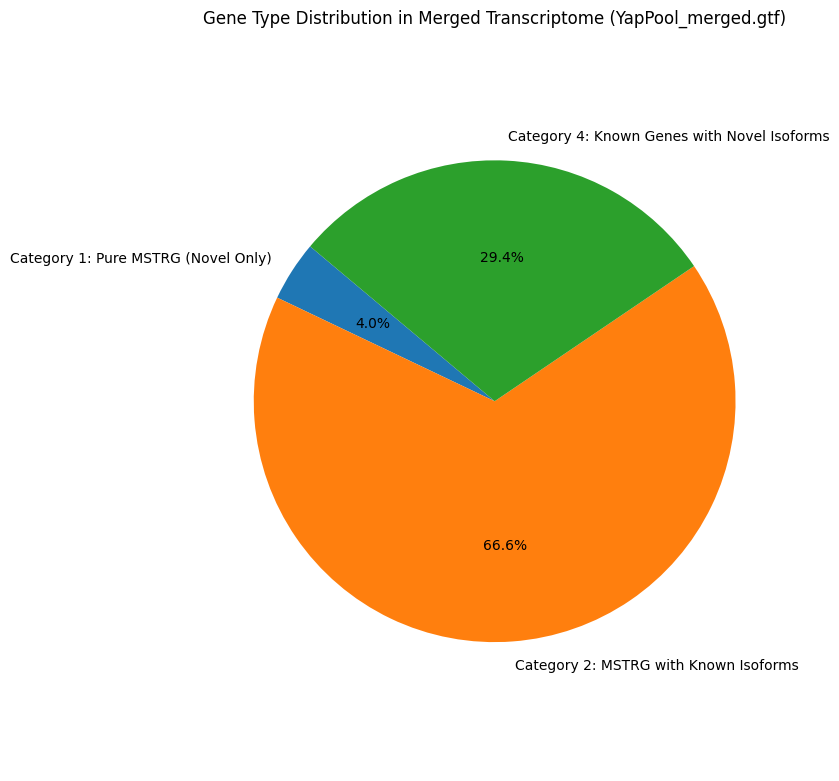

In [ ]:
import matplotlib.pyplot as plt

labels = [
    'Category 1: Pure MSTRG (Novel Only)',
    'Category 2: MSTRG with Known Isoforms',
    'Category 4: Known Genes with Novel Isoforms'
]
sizes = [1162, 19157, 8466]

# Plot
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Gene Type Distribution in Merged Transcriptome (YapPool_merged.gtf)')
plt.axis('equal')
plt.tight_layout()
plt.show()

> Figure 1. Distribution of transcriptome gene types in the merged annotation (YapPool_merged.gtf). The majority of transcriptomes are novel MSTRG genes that overlap with known reference isoforms (Category 2), while 8,466 are known genes (e.g., ENSGALG) that include novel isoforms assembled during transcriptome reconstruction (Category 4). Only 1,162 genes were fully novel (Category 1), with no detectable overlap to known annotations. No pure known transcriptomes (Category 3) were retained due to StringTie's merging behavior.

***
### **Transcript Diversity per Gene**

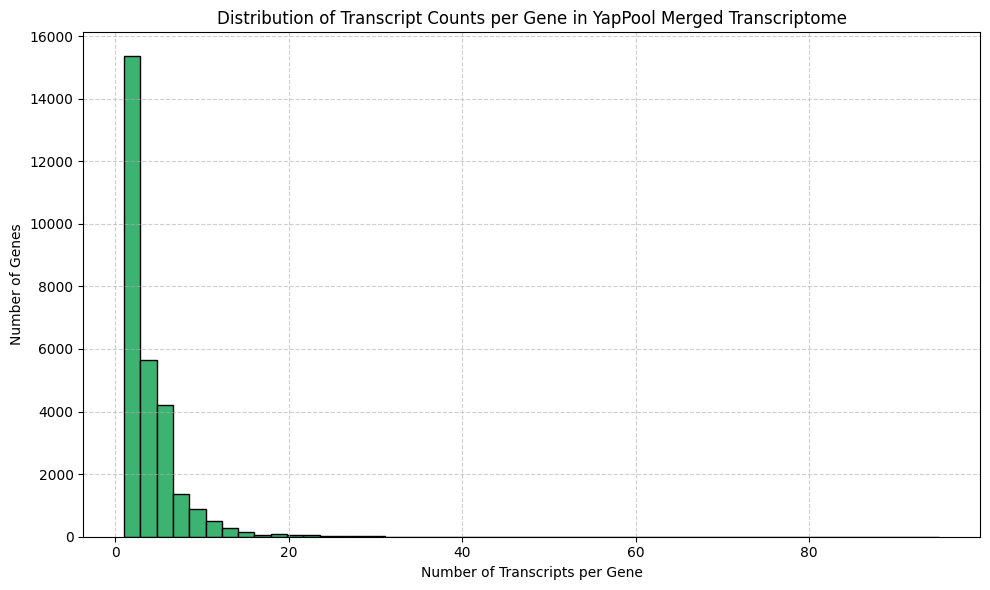

In [ ]:
import matplotlib.pyplot as plt

# Count how many transcripts each gene has
transcript_counts = [len(ts) for ts in gene_transcripts.values() if len(ts) > 0]

# Plot
plt.figure(figsize=(10,6))
plt.hist(transcript_counts, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Distribution of Transcript Counts per Gene in YapPool Merged Transcriptome')
plt.xlabel('Number of Transcripts per Gene')
plt.ylabel('Number of Genes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

> Figure 2. Histogram showing the distribution of transcript counts per gene in the merged transcriptome (YapPool_merged.gtf). Most genes have fewer than 10 transcripts, while a smaller subset shows high transcript diversity due to alternative splicing or gene complexity captured during StringTie assembly.

***
### **Examples of Novel Transcripts Overlapping Known Annotations**

In [ ]:
# Intersect MSTRG transcripts with reference transcripts, keeping both sides (with annotations)
overlapping = mstrg_transcripts.intersect(ref_transcripts, wa=True, wb=True)

# Show 5 formatted examples
print("Example Overlapping MSTRG Transcripts:\n")
for i, feature in enumerate(overlapping):
    print("MSTRG Transcript:")
    print("  ", "\t".join(feature.fields[:9]))
    print("Reference Transcript Overlap:")
    print("  ", "\t".join(feature.fields[9:]))
    print("-" * 60)
    if i == 4:
        break

Example Overlapping MSTRG Transcripts:

MSTRG Transcript:
   1	StringTie	transcript	56512	75455	1000	-	.	gene_id "MSTRG.3"; transcript_id "MSTRG.3.1"; 
Reference Transcript Overlap:
   1	ensembl	mRNA	56535	61129	.	-	.	ID=transcript:ENSGALT00010012882;Parent=gene:ENSGALG00010005414;biotype=protein_coding;tag=Ensembl_canonical;transcript_id=ENSGALT00010012882;version=1
------------------------------------------------------------
MSTRG Transcript:
   1	StringTie	transcript	56512	75455	1000	-	.	gene_id "MSTRG.3"; transcript_id "MSTRG.3.1"; 
Reference Transcript Overlap:
   1	ensembl	mRNA	67865	69817	.	-	.	ID=transcript:ENSGALT00010012895;Parent=gene:ENSGALG00010005419;biotype=protein_coding;tag=Ensembl_canonical;transcript_id=ENSGALT00010012895;version=1
------------------------------------------------------------
MSTRG Transcript:
   1	StringTie	transcript	56512	75455	1000	-	.	gene_id "MSTRG.3"; transcript_id "MSTRG.3.1"; 
Reference Transcript Overlap:
   1	ensembl	mRNA	70300	79465	.	-	.	

> Table 2. Examples of novel MSTRG transcripts overlapping with reference transcripts in the Gallus gallus genome. Each MSTRG transcript assembled by StringTie shows coordinate-level intersection with one or more known Ensembl mRNAs (e.g., ENSGALT00010012882, ENSGALT00010012895). These overlaps confirm that many "novel" transcripts may represent extended, truncated, or alternatively spliced forms of known isoforms, supporting their classification under Category 2 (novel transcriptome with both known and novel isoforms).

In [ ]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/HeraDashnyam/ResTask02/YapPool_Transcript_Categories.xlsx")

# Infer group if it doesn't exist
if "group" not in df.columns:
    def assign_group(row):
        if row["gene_id"].startswith("MSTRG"):
            return "novel_overlap" if isinstance(row["ref_gene_id"], str) and row["ref_gene_id"].strip() != "" else "novel_no_overlap"
        else:
            return "known_overlap" if isinstance(row["ref_gene_id"], str) and row["ref_gene_id"].strip() != "" else "known_no_overlap"

    df["group"] = df.apply(assign_group, axis=1)

# Create the tally table
tally_table = (
    df.groupby("group")
      .agg(
          Unique_Genes=("gene_id", pd.Series.nunique),
          Unique_Transcripts=("transcript_id", pd.Series.nunique)
      )
      .reset_index()
)

tally_table

,group,Unique_Genes,Unique_Transcripts
0,known_overlap,8466,17711
1,novel_no_overlap,9899,28015
2,novel_overlap,19157,54891


>Table 3. Summary of transcript and gene counts grouped by transcript novelty and overlap with known reference annotations.
Transcripts were classified using a derived group column based on two features:

gene_id: Transcripts with gene_id starting with "MSTRG" were labeled as novel, while all others were considered known.

ref_gene_id: Presence of a non-empty ref_gene_id indicated overlap with known annotations.

The resulting groups were interpreted as follows:

novel_no_overlap → fully novel transcriptomes (Category 1)

novel_overlap → novel transcriptomes overlapping known isoforms (Category 2)

known_no_overlap → rare entries, possibly misassemblies (Category 3)

known_overlap → known transcriptomes with novel isoform activity (Category 4)

This summary was generated by grouping the DataFrame on group and counting the number of unique gene_id and transcript_id entries within each category.

***
###**Code for Sub-Task 02b: Hypothesis Test**

In [ ]:
# Define novelty and overlap
df['is_novel'] = df['gene_id'].str.startswith('MSTRG')
df['overlaps_reference'] = df['ref_gene_id'].apply(lambda x: isinstance(x, str) and x.strip() != "")

# Count totals
novel_total = df[df['is_novel']].shape[0]
novel_overlap_count = df[(df['is_novel']) & (df['overlaps_reference'])].shape[0]
novel_nonoverlap = novel_total - novel_overlap_count

# Display result
print("Hypothesis Test: Do novel transcripts overlap reference annotations?\n")
print(f"Total novel transcripts: {novel_total:,}")
print(f"Novel transcripts overlapping reference: {novel_overlap_count:,}")
print(f"Novel transcripts with no overlap: {novel_nonoverlap:,}\n")

# Evaluate
if novel_overlap_count > 0:
    print("❌ Hypothesis Rejected: Some novel transcripts DO overlap with reference annotations.")
else:
    print("✅ Hypothesis Supported: No novel transcripts overlap with reference.")

Hypothesis Test: Do novel transcripts overlap reference annotations?

Total novel transcripts: 82,906
Novel transcripts overlapping reference: 54,891
Novel transcripts with no overlap: 28,015

❌ Hypothesis Rejected: Some novel transcripts DO overlap with reference annotations.


***
###**Bar Plot and Pie Chart of Transcript Groups**

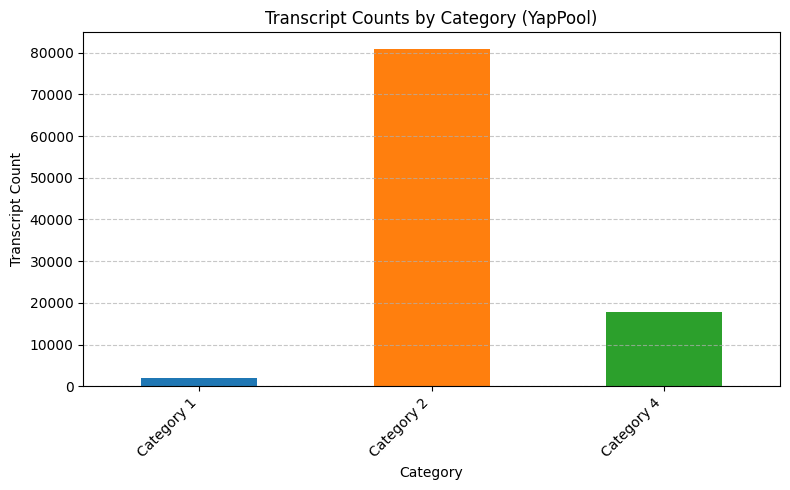

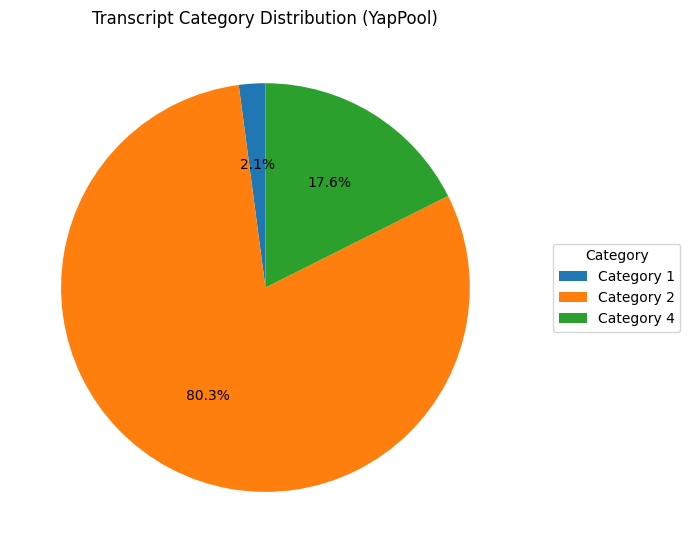

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("/content/drive/MyDrive/HeraDashnyam/ResTask02/YapPool_Transcript_Categories.xlsx")

# Count transcripts in each category and sort for consistent color mapping
category_counts = df["category"].value_counts().sort_index()

# Generate a color palette (up to 10 distinct colors)
color_list = list(plt.cm.tab10.colors)[:len(category_counts)]

# Bar Plot
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=color_list)
plt.title("Transcript Counts by Category (YapPool)")
plt.xlabel("Category")
plt.ylabel("Transcript Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(category_counts, labels=None, autopct="%1.1f%%", startangle=90, colors=color_list)
plt.title("Transcript Category Distribution (YapPool)")
plt.legend(labels=category_counts.index, title="Category", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.tight_layout()
plt.show()


> Figure 3 & 4. Distribution of transcript counts by category based on the merged and annotated transcriptome from YapPool_Transcript_Categories.xlsx.

Category 1 represents novel transcriptomes with only novel isoforms (fully novel MSTRG genes) — these account for only ~2.1% of the dataset.

Category 2 includes novel transcriptomes that overlap known isoforms — the largest group (~80.3%), showing that most "novel" transcripts are extended or spliced variants of known genes.

Category 4 represents known transcriptomes (e.g., ENSGALG genes) with both known and novel isoforms — making up ~17.6% of transcripts.

The bar chart displays absolute transcript counts per category, while the pie chart shows proportional distribution. These visualizations confirm that the majority of reconstructed transcripts have clear connections to known annotations, supporting the dominant role of Category 2 in transcriptome complexity.

***
## **Visualizing in IGV**
To further verify and explore transcript structure, we used the Integrative Genomics Viewer (IGV) to examine specific genomic regions in detail.

###**Setup**
* Load the GRCg7b reference genome into IGV.

* Load the aligned RNA-Seq BAM file (indexed) and the YapPool_merged.gtf file as a custom annotation track.

* Made sure the GTF is sorted and indexed using IGVtools for smooth rendering.

###**Focus Regions**
We visually inspected 10 regions selected for their biological interest, structural novelty, and relevance to transcriptome annotation:

* Figures 1–3: MSTRG transcripts that directly overlap with known Ensembl transcripts, supporting novel isoform discovery.

* Figures 4–6: Alternative exon usage, structural divergence, or unexpected transcript patterns not captured by RefSeq/Ensembl.

* Figure 7: A strand discrepancy between annotated and assembled transcripts, raising questions about directionality or misannotation.

* Figure 8: A super-transcript or potential fusion isoform spanning multiple Ensembl genes.

* Figure 9: A novel transcript overlapping CpG islands in a regulatory-rich region.

* Figure 10: A readthrough transcript linking two known genes (COG5 → DUS4L) with implications for bicistronic expression or fusion activity.

###**Why IGV Matters**
This visual inspection:

* Confirms transcript structure predicted by computational tools

* Reveals novel isoforms, alternative splicing, and misannotations

* Connects transcript boundaries to regulatory features (e.g., CpG islands)

* Strengthens biological interpretation of RNA-Seq data beyond numeric analysis

###**Using IGV:**

1. Open IGV and select the correct genome (e.g., Gallus gallus if available).

2. Load your .bam and .gtf files using File → Load from File.

3. Search for specific gene_id or transcript_id in the search bar (e.g., MSTRG.2.)

4. Use the tracks to compare reference annotations vs. your novel transcripts.

**Transcript structures:**

* Arrows show strand orientation.

* Boxes represent exons; connecting lines show introns.

* Darker boxes = CDS; lighter = UTRs.

**Figure 1. Overlap between novel transcript `MSTRG.3.1` and known Ensembl gene `ENSGALT00010012882.1` on chr1 (56,535–61,129 bp).**  
The novel transcript discovered from RNA-Seq closely mirrors the structure of a known gene, including exon-intron boundaries and strand orientation. This supports its classification as a novel isoform or rediscovery of an existing gene under a new identifier due to assembly-driven transcript labeling.
![1](https://drive.google.com/uc?id=1TykPX40muk0elKvF0NAkVB7kT9NdOgjv)

**Figure 1B. Alternative view of `MSTRG.3.1` overlapping `ENSGALT00010012882.1` on chr1.**  
This zoomed-in panel reinforces the structural alignment between the novel and known transcript, while additionally revealing a CpG island in the region — suggesting potential regulatory activity.

**P.S.:** AUGUSTUS is a gene prediction tool used to identify gene structures (e.g., exons, introns, UTRs) ab initio — based solely on sequence. On IGV, AUGUSTUS tracks show predicted gene models in a genome, which helps validate novel transcript predictions or uncover missed genes.

![1b](https://drive.google.com/uc?id=18v-21g8rpD_tJL1Q71PHYpgJ_QZqzI8R)

**Figure 2. Overlap between novel transcript `MSTRG.3.1` and Ensembl gene `ENSGALT00010012895.1` on chr1 (67,865–69,817 bp).**  
While the core exon structure of `MSTRG.3.1` overlaps with both Ensembl and RefSeq-predicted transcripts, it includes an upstream extension and minor structural differences. This may reflect a novel 5' isoform or incomplete transcript reconstruction from RNA-Seq data.
![2](https://drive.google.com/uc?id=1pomYnc9xQA3UUDi289E1LQJspNYh5odq)

**Figure 3. Overlapping novel transcripts `MSTRG.3.1–3.3` with Ensembl gene `ENSGALT00010018734.1` on chr1 (70,300–79,465 bp).**  
Multiple novel transcripts identified by StringTie align with a known gene locus, but differ in exon boundaries and transcript length. These findings suggest novel isoforms or extended untranslated regions, consistent with alternative splicing and transcript diversity in this region.
![3](https://drive.google.com/uc?id=1IPyn8S0aYr_nU_5lGK1dQpYXv21unBkZ)

**Figure 3B. Extended view of `MSTRG.3.1–3.3` and Ensembl gene `ENSGALT00010018734.1` on chr1 (71,728–79,479 bp).**  
This broader view shows the full extent of overlapping novel transcripts and their alignment with known gene annotations, illustrating isoform diversity and potential upstream regulatory elements.
![3b](https://drive.google.com/uc?id=1Lfq0mvuXwyzNdVE37_pMt-k5bdWUsNfX)

**Figure 4. Novel transcript `MSTRG.74.1` shows truncated alignment relative to annotated RefSeq gene `NM_001030647.1` on chr1 (1,425,071–1,433,292 bp).**  
While both Ensembl and RefSeq predict a multi-exon gene across this region, `MSTRG.74.1` appears as a short, possibly truncated transcript aligning only to the 3′ end. This may reflect an incomplete assembly, alternative polyadenylation, or transcript degradation pattern captured in RNA-Seq data.
![4](https://drive.google.com/uc?id=1j02hIXDUUcn0R31ajyAQysdXBRHwwdo8)

**Figure 5. Alternative exon structure of StringTie transcript `TASOR2` relative to Ensembl gene `ENSGALT00010016225.1` on chr1 (1,636,230–1,638,284 bp).**  
The novel transcript diverges from both RefSeq and Ensembl annotations by incorporating modified exon boundaries and potential additional internal exons. This pattern supports the presence of alternative splicing or structural variation not captured by current genome annotations.
![5](https://drive.google.com/uc?id=10UbpFU3vGxtP-eFaXnZuIeLVcfeYYmMq)

**Figure 6. Divergent novel transcript structure in the absence of Ensembl annotation on chr1 (2,451,034–2,459,255 bp).**  
This reverse-strand transcript displays unique exon junctions and compaction compared to RefSeq (`XM_040663663.1`) and Augustus gene predictions (`g69.t1`). Its presence in a region lacking Ensembl annotation suggests a novel splicing variant or a misannotated gene model in current genome releases.
![6](https://drive.google.com/uc?id=1rtZjksB5F45gHgXolLGnX4bBl3GR1WTE)

**Figure 7. Strand mismatch between assembled and annotated transcript `ENSGALT00010018552.1` on chr1 (5,931,182–5,935,292 bp).**  
The assembled transcript appears structurally identical to its Ensembl annotation, but is assigned to the opposite strand. This discrepancy may stem from RNA-Seq assembly limitations or indicate potential bidirectional transcription. Further investigation is needed to resolve strand origin.
![7](https://drive.google.com/uc?id=1XNUkhHYtfsv0vK89oZvKsD6Q0HOXUAzw)

**Figure 8. Extended novel transcript `MSTRG.165.1` spanning multiple Ensembl gene models on chr1 (7,363,894–7,368,004 bp).**  
The StringTie-assembled `MSTRG.165.1` transcript extends across at least three annotated Ensembl transcripts (`ENSGALT00010018344.1`, `...18347.1`, `...18349.1`) with overlapping exons and a continuous splicing pattern. This structure suggests a possible gene fusion, super-transcript, or unannotated long isoform not captured by existing annotations.
![8](https://drive.google.com/uc?id=1lYX2AF7y6orbNUY5cWos0mbVvN9mByxb)

**Figure 9. Novel transcript `MSTRG.230.1` extends across two annotated Ensembl genes and CpG islands on chr1 (13,908,714–13,925,157 bp).**  
`MSTRG.230.1` spans the region containing two Ensembl transcripts and overlaps multiple CpG islands, suggesting possible regulatory involvement. Its extended structure may indicate gene fusion, read-through transcription, or an unannotated long non-coding RNA in a transcriptionally active domain.
![9](https://drive.google.com/uc?id=1qInhlpNP-IbwNmdaudYjgjSjpJNow5wJ)

**Figure 10. Readthrough transcript connecting `COG5` and `DUS4L` across multiple gene annotations on chr1 (14,937,315–14,941,425 bp).**  
The StringTie assembly includes a transcript that bridges two annotated genes, `COG5` and `DUS4L`, overlapping multiple Ensembl and RefSeq predictions and passing through a CpG island. This readthrough pattern may represent a functional bicistronic transcript, an unannotated fusion, or a regulatory variant, highlighting the dynamic complexity of gene expression in this region.
![10](https://drive.google.com/uc?id=18qQYmxjvP1xhZLVsFUsX4eL7z_SZmuF9)

In [ ]:
import pandas as pd
import re

# Load your merged GTF file
gtf = pd.read_csv(
    "/content/drive/MyDrive/HeraDashnyam/YapPool_merged.gtf",
    sep="\t",
    comment="#",
    header=None,
    names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"],
    low_memory=False
)

# Filter for chromosome 1 region spanning COG5 and DUS4L (wider window)
region = gtf[
    (gtf["seqname"] == "1") &  # No 'chr' prefix, just '1'
    (gtf["start"] >= 14937000) &
    (gtf["end"] <= 14942000) &
    (gtf["feature"].isin(["gene", "transcript", "exon"]))
]

# Function to extract ID fields
def extract_id(field, key):
    match = re.search(f'{key} "([^"]+)"', field)
    return match.group(1) if match else None

# Add gene_id and transcript_id columns
region["gene_id"] = region["attribute"].apply(lambda x: extract_id(x, "gene_id"))
region["transcript_id"] = region["attribute"].apply(lambda x: extract_id(x, "transcript_id"))

# Sort and view
region_sorted = region[["feature", "start", "end", "strand", "gene_id", "transcript_id"]].drop_duplicates().sort_values("start")
region_sorted.head(50)

<ipython-input-29-daca7ccb1721>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region["gene_id"] = region["attribute"].apply(lambda x: extract_id(x, "gene_id"))
<ipython-input-29-daca7ccb1721>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region["transcript_id"] = region["attribute"].apply(lambda x: extract_id(x, "transcript_id"))


,feature,start,end,strand,gene_id,transcript_id
11651,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021820
11674,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021843
11696,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021885
11718,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021866
11740,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021805
11763,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021777
11779,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021747
11771,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021762
11787,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021736
11795,exon,14937998,14938055,-,MSTRG.250,ENSGALT00010021718


In [ ]:
target_gene = "MSTRG.250"

readthrough_structure = gtf[
    (gtf["feature"] == "exon") &
    (gtf["attribute"].str.contains(f'gene_id "{target_gene}"'))
].sort_values("start")

readthrough_structure[["seqname", "start", "end", "strand", "attribute"]]

,seqname,start,end,strand,attribute
11632,1,14755673,14757292,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11655,1,14755693,14757292,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11678,1,14755693,14757292,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11700,1,14755693,14757292,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11722,1,14756628,14757292,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
...,...,...,...,...,...
11781,1,14939716,14940205,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11773,1,14939716,14940205,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11765,1,14939716,14940205,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."
11789,1,14939716,14940205,-,"gene_id ""MSTRG.250""; transcript_id ""ENSGALT000..."


In [ ]:
readthrough_structure[["seqname", "start", "end", "strand"]].to_csv("MSTRG250_Exon_Structure.csv", index=False)

In [ ]:
readthrough_structure["transcript_id"] = readthrough_structure["attribute"].str.extract(r'transcript_id\s+"([^"]+)"')
unique_transcripts = readthrough_structure["transcript_id"].dropna().unique()
print("Ensembl Transcripts Involved:")
for tid in unique_transcripts:
    print(f" - {tid}")

Ensembl Transcripts Involved:
 - ENSGALT00010021820
 - ENSGALT00010021843
 - ENSGALT00010021885
 - ENSGALT00010021866
 - ENSGALT00010021805
 - ENSGALT00010021777
 - ENSGALT00010021762
 - ENSGALT00010021747
 - ENSGALT00010021736
 - ENSGALT00010021718


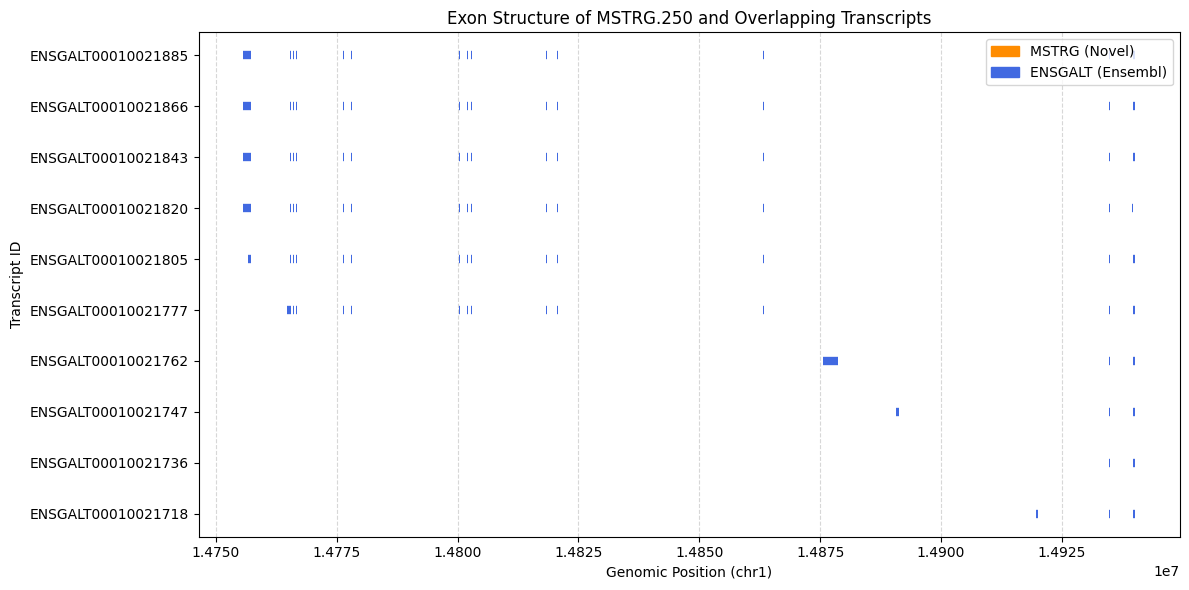

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load merged GTF file
gtf_path = "/content/drive/MyDrive/HeraDashnyam/YapPool_merged.gtf"

# Read GTF file as DataFrame
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    comment="#",
    header=None,
    names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"],
    low_memory=False
)

# Filter only 'exon' features
exons = gtf[gtf["feature"] == "exon"].copy()

# Extract gene_id and transcript_id from the 'attribute' column
def extract_id(attr, key):
    import re
    match = re.search(f'{key} "([^"]+)"', attr)
    return match.group(1) if match else None

exons["gene_id"] = exons["attribute"].apply(lambda x: extract_id(x, "gene_id"))
exons["transcript_id"] = exons["attribute"].apply(lambda x: extract_id(x, "transcript_id"))

# 🔍 Focus on MSTRG.250 and overlapping ENSGALT transcripts
target_gene = "MSTRG.250"
target_df = exons[exons["gene_id"] == target_gene].copy()

# Also extract all ENSGALT transcripts that co-occur with MSTRG.250
overlapping_transcripts = exons[
    (exons["start"].isin(target_df["start"])) &
    (exons["end"].isin(target_df["end"])) &
    (exons["gene_id"] != target_gene)
]

# Combine both
plot_df = pd.concat([target_df, overlapping_transcripts], ignore_index=True)

# Sort for visual clarity
plot_df = plot_df.sort_values(by=["transcript_id", "start"])

# Assign a unique y-position for each transcript
transcript_order = {tid: i for i, tid in enumerate(plot_df["transcript_id"].unique())}
plot_df["y"] = plot_df["transcript_id"].map(transcript_order)

# Plotting
plt.figure(figsize=(12, 6))
for _, row in plot_df.iterrows():
    color = "royalblue" if "ENSGALT" in row["transcript_id"] else "darkorange"
    plt.hlines(y=row["y"], xmin=row["start"], xmax=row["end"], colors=color, linewidth=6)

# Formatting
plt.yticks(list(transcript_order.values()), list(transcript_order.keys()))
plt.xlabel("Genomic Position (chr1)")
plt.ylabel("Transcript ID")
plt.title(f"Exon Structure of MSTRG.250 and Overlapping Transcripts")

# Legend
legend_patches = [
    mpatches.Patch(color="darkorange", label="MSTRG (Novel)"),
    mpatches.Patch(color="royalblue", label="ENSGALT (Ensembl)")
]
plt.legend(handles=legend_patches, loc="upper right")

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

>Figure 5. Exon structure comparison between MSTRG.250 and overlapping Ensembl transcripts (ENSGALT series) on chromosome 1.
Each row represents a transcript; each bar is an exon.
The near-perfect alignment of exonic positions between MSTRG.250 and 10 Ensembl isoforms supports the hypothesis that MSTRG.250 represents a multi-locus transcript spanning both COG5 and DUS4L, potentially a readthrough or novel regulatory RNA.